In [1]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds, orthant_bounds_optimized
from MGTomo.gridop import RBox as R, PBox as P
from MGTomo import gridop

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch_scatter
from torch.linalg import matrix_norm

import time
import numpy as np


from torch.profiler import record_function, profile, ProfilerActivity

In [28]:
N = 1023
max_levels = 1
maxIter = [1,100,60,32,64,128]

In [3]:
(120+32+64+128)*0.04/60

0.22933333333333333

In [4]:
from PIL import Image
import numpy as np

image = Image.open('vessel.png').convert('L')
image_np = np.array(image)
resized_image = image.resize((N, N))

resized_image_np = np.array(resized_image)/255


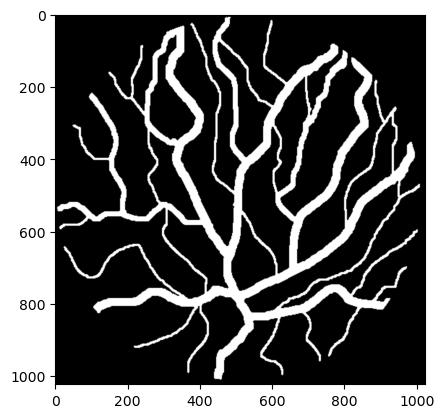

In [5]:
plt.imshow(resized_image_np, cmap='gray')

In [6]:
x_torch = torch.tensor(resized_image_np)
A = [x_torch.bernoulli(0.5)]
b = [A[0] * x_torch]

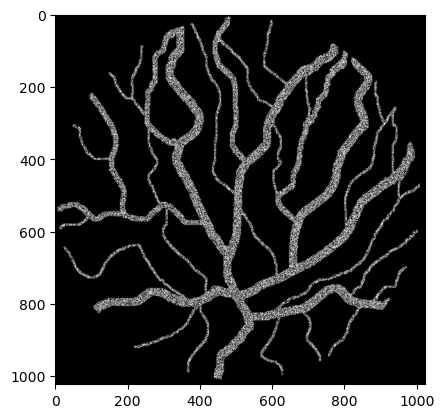

In [7]:
plt.imshow(b[0].detach().numpy(), cmap='gray')

In [8]:
P_nonzero = []
fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(resize(A[-1], (coarse_dim, coarse_dim), anti_aliasing=False))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim


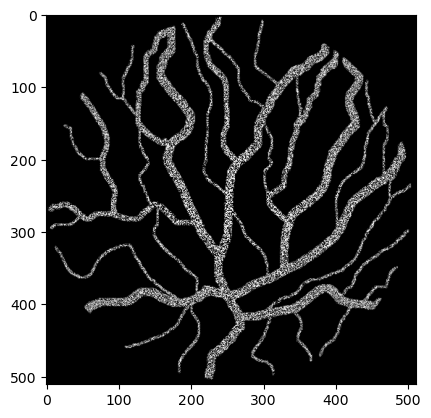

In [9]:
plt.imshow(b[1].detach().numpy(), cmap='gray')

In [10]:
fh = lambda x: fcts.kl_distance_rev_pointwise(x, b[0], A[0])
tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
P_inf = 1

In [11]:
tau

[tensor(0.0018, dtype=torch.float64),
 tensor(0.0035, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0080, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0162, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.0320, dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor(0.1057, dtype=torch.float64, grad_fn=<MulBackward0>)]

In [12]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

norm_fval_SL = []
norm_fval_SL.append(torch.tensor(1.))

fhw = fh(w0)
w0.retain_grad()
fhw.backward(retain_graph=True)
Gw0 = matrix_norm(w0.grad)
w0.grad = None

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

norm_grad_SL = []
norm_grad_SL.append(torch.tensor(1.))


for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val = fcts.mirror_descent_IS(fh, w0, tau[0], lh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())

    fval = fh(w0)
    norm_fval_SL.append((fh(w0)/fhw).item())
    fval.backward(retain_graph=True)
    norm_grad_SL.append((matrix_norm(w0.grad)/Gw0).item())
    w0.grad = None
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 229226.26150271104 - Time: 0.053594 seconds
Iteration 1: 228994.53596900273 - Time: 0.038500 seconds
Iteration 2: 228763.2339784282 - Time: 0.037178 seconds
Iteration 3: 228532.35992116632 - Time: 0.033691 seconds
Iteration 4: 228301.90524291142 - Time: 0.033866 seconds
Iteration 5: 228071.85707896712 - Time: 0.034181 seconds
Iteration 6: 227842.24088827358 - Time: 0.036355 seconds
Iteration 7: 227613.04829737934 - Time: 0.042610 seconds
Iteration 8: 227384.26221981482 - Time: 0.039037 seconds
Iteration 9: 227155.89961417753 - Time: 0.038346 seconds
Iteration 10: 226927.94789373805 - Time: 0.035591 seconds
Iteration 11: 226700.4111158641 - Time: 0.037174 seconds
Iteration 12: 226473.293529945 - Time: 0.038068 seconds
Iteration 13: 226246.5823328838 - Time: 0.038791 seconds
Iteration 14: 226020.27362420302 - Time: 0.037635 seconds
Iteration 15: 225794.3881168474 - Time: 0.037307 seconds
Iteration 16: 225568.91340725415 - Time: 0.037058 seconds
Iteration 17: 225343.832394830

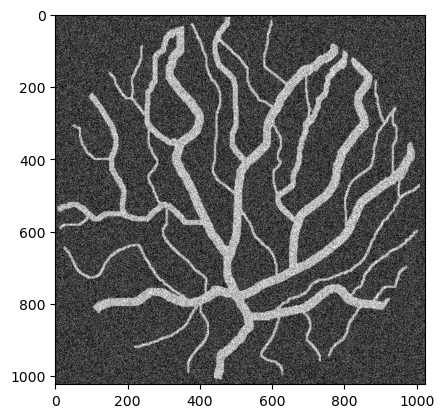

In [13]:
plt.imshow(w0.detach().numpy(), cmap='gray')

In [19]:
def MLO_orthant(fh, y, lh, last_pts: list, l=0, kappa = 0.1, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph=True)
    grad_fhy0 = y.grad.clone()
    y.grad = None
    
    #if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
    if True:
        print(l, ' : coarse correction activated')
        last_pts[l] = y.detach()

        with record_function("establish CM"):
        
            x0 = x.detach().requires_grad_(True)
            fH = lambda x: fcts.kl_distance_rev_pointwise(x, b[l+1], A[l+1])
            fHx0 = fH(x0)
            fHx0.backward(retain_graph = True)
            grad_fHx0 = x0.grad.clone()
            x0.grad = None

            kappa = R(grad_fhy0) - grad_fHx0

            del grad_fHx0
            with record_function("computing bounds"):
                with torch.no_grad():
                    psi = lambda x: fH(x) + torch.sum(kappa * x)
                    lH = orthant_bounds_optimized(y, x, P_inf, lh, P_nonzero[l])
        
        with record_function("solving CM"):
            for i in range(maxIter[l+1]):
                #x.retain_grad()
                x = fcts.mirror_descent_IS(psi, x, tau[l+1], lH).detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_orthant(psi, x, lH, last_pts, l+1)

        d = P(x-x0)
        with record_function("line search"):
            z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')
    
    with record_function("solving FP"):
        for i in range(maxIter[l]):
            y = fcts.mirror_descent_IS(fh, y, tau[l], lh).detach().requires_grad_(True)
    return y, last_pts


In [29]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

norm_fval = []
norm_fval.append(torch.tensor(1.))

fhz = fh(z0)

fhz.backward(retain_graph=True)
Gz0 = matrix_norm(z0.grad)
z0.grad = None

norm_grad = []
norm_grad.append(torch.tensor(1.))

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(3):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_orthant(fh, z0, lh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    fval = fh(z0)
    norm_fval.append((fval/fhz).item())
    fval.backward(retain_graph=True)
    norm_grad.append((matrix_norm(z0.grad)/Gw0).item())
    z0.grad = None
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
Iteration 0: 223587.94922939496 - Time: 2.813538 seconds
0  : coarse correction activated
Iteration 1: 218035.2092102358 - Time: 2.844554 seconds
0  : coarse correction activated
Iteration 2: 212775.32127240716 - Time: 2.799504 seconds
Overall time for all iterations: 8.565022 seconds


In [30]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("MLO"):
        MLO_orthant(fh, z0, lh, last_pts)

0  : coarse correction activated


In [31]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                    MLO         0.05%       1.704ms       100.00%        3.413s        3.413s             1  
                                             solving CM         3.31%     113.058ms        63.71%        2.175s        2.175s             1  
                                 aten::_index_put_impl_        27.97%     954.747ms        33.78%        1.153s       1.869ms           617  
                                           establish CM         0.03%     877.311us        32.95%        1.125s        1.125s             1  
      

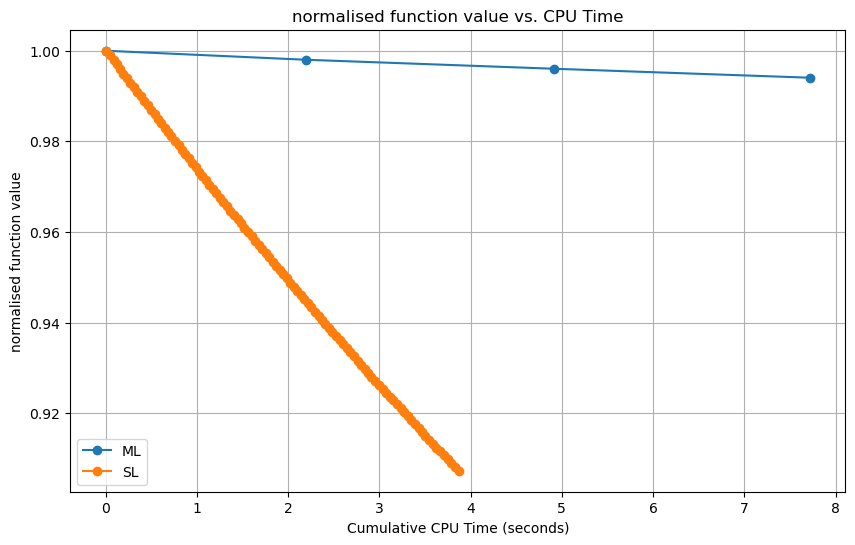

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, norm_fval, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, norm_fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('normalised function value')
plt.title('normalised function value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()